# Plagiarism Detector 
### References are in the bottom 

Shingling + Jaccard Similarity + MiniHash was provided by:
- https://github.com/elhamsharifi?tab=repositories. 
- https://github.com/vgole001/Count-Distinct-Items-using-Min-Hash-and-LSH/blob/master/MinHash_LSH.ipynb
- https://github.com/daanknoors/LSH/blob/master/ItemSimilarity.py

we changed most of the stuffs and tried not use their exact code, however, you mentioned that we can use the already implemented classes for Shingling + Jaccard Similarity + MiniHash

In [1]:
from tqdm import tqdm, trange, tqdm_notebook 
import json
import numpy as np
import binascii
from time import time
from time import sleep
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import string
from collections import defaultdict
import random
import pandas as pd
import re
import math


In [27]:
%%time


print("")
filename = "C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Our Data/News_1000.txt"



Wall time: 0 ns


## 4.1 Pre-processing of data
we are preprocessing all texts from the given documents. Transforming all the letters in lower case. We are doing tokenization meaning that each word becomes a token. Removing all Symbols. We are reading all the data and separated the news_id from the news body.
- Read all of the words (they are all on one line) and split them by white space.
- Retrieve the article ID, which is the first word on the line.  


In [11]:
def Pre_Process_data(filename):

    array_of_doc_tuples=[]
    # read lines from filename
    #with open((filename)) as fp:
     #   for line in fp:
        
    f=open(filename,'r') 
    lines=f.readlines()
    for line in lines:
        
    
    # construct tuple of doc_Id and text
            doc_Id = line.split(' ')[0]
            text = str(line.split(' ')[1:])
            
    # process string as described above
            for ch in string.punctuation:                                                                                                     
                text=text.replace(ch, "")
#                 print(text)
            
            text=text.lower()
            text=text.replace("  ", "")
            
            tuples=(doc_Id,text)
#           print(tuples)
            array_of_doc_tuples.append(tuples)
    
    # return tuple with doc_Id and processed string
            
            print(array_of_doc_tuples)
    return array_of_doc_tuples



### Shingling
Create a dictionary of the articles, mapping the Id (e.g.,"470") to the list of shingle IDs that appear in the document.
- Construct the shingle text by combining three words together.
- Hash the shingle to a 32-bit integer.
- Add the hash value to the list of shingles for the current document. 



In [17]:
def shingle_document(string, k):
    
    # initialize set data structure
    set_data_structure=set()
    # for each position in string, extract substring of length k
    
    for i in range (len(string)-k+1):
        substring_length_k=string[i:i+k]
        
    # hash into 32-bit integer
        hash_substring=binascii.crc32( substring_length_k.encode())
        
    # insert into set
        set_data_structure.add(hash_substring)
    return (set_data_structure)


## 4.2 Calculating Jaccard similarities 
We will directly calculate the Jaccard similarities by comparing the sets. Jaccard similarity in here is much slower than the MinHash approach.




In [21]:
def jaccard(a, b):
  # compute union size
    union_size = len(set(a).union(set(b)))
  # compute intersection size
    intersection_size=len(set(a).intersection(set(b)))
  
    # another way 
    #     a = set(a)
    #     b = set(b)
    #     return (len(a.intersection(b)) / len(a.union(b)))


    # return ratio of union and intersection
    return 1.0*intersection_size/union_size



### Putting everything together
Computes the Minhash estimated similarities between each pair of documents

In [22]:

pair_tuples=[]
array_of_jaccard_tuples=[]

def jaccard_of_documents(file_name, k):
    
    array_of_documents_tuples = Pre_Process_data(file_name)
    array_of_jaccard_tuples=[]

    for i in range(len(array_of_documents_tuples)):
        for j in range (i+1, len(array_of_documents_tuples)):
            
            a = shingle_document( array_of_documents_tuples[i][1] , k )
            b = shingle_document(array_of_documents_tuples[j][1], k)
            jaccard_similarity = jaccard(a,b)
            
            # array_of_documents_tuples[i][0]  for the first doc_id eg. "10"
            # array_of_documents_tuples[j][0]  for the second doc_id eg. "1-1000" comparing it with "10"
            # jaccard_similarity = similarity score between 0 and 1, 
            jaccard_tuples = (array_of_documents_tuples[i][0],array_of_documents_tuples[j][0],jaccard_similarity)
            
            # similarity threshold is >0.80 => higher than 80% similarity
            if jaccard_similarity>=0.80:
                print (jaccard_tuples)
                pair_tuples.append(jaccard_tuples)
            array_of_jaccard_tuples+=[jaccard_tuples]
            
    return array_of_jaccard_tuples, jaccard_similarity

### Generating ground-truth data 
 Here we used the News_1000.txt which we found it online and contain 1000 articles 

In [ ]:
%%time

array_of_jaccard_tuples=jaccard_of_documents("C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Our Data/News_1000.txt",10)

### Bar plot
- storing the candidate pairs that has a similarity > 0 , we use this to find the similar pairs to show them on the bar graph
- after that, run the same code to get the higher candidate pairs that has a similarity than 80%, we use these tuples for the LSH later

In [ ]:
%%time
# print(pair_tuples)
# print(pair_tuples[0][1])

#shows the num of pairs
print(len(pair_tuples),"pairs")

doc1=[]
doc2=[]
similarity=[]
for i in range (len(pair_tuples)):
        docs = pair_tuples[i][0]
        doc1.append(docs)
        docs1 = pair_tuples[i][1]
        doc2.append(docs1)
                
for i in range (len(pair_tuples)):
    similar = 100 * pair_tuples[i][2]
    similarity.append(similar)

### exporting the similair pairs to a file which will be used later as ground-truth data for the LSH
- Because it the jaccard similarity so we stored the similarity of the pairs also, but later we removed them when we used for the LSH.
- If you don't want to export it, you can easily remove it from the jaccard_of_documents() line 16 last parameter

In [ ]:
%%time
# Write similar pair documents to a file
with open('Candidate pairs.txt', 'w+') as fp:
    fp.write('Similarity between documents using the Jaccard distance: \n')
    for sims in pair_tuples:
        fp.write('\t'.join('%s' % s for s in sims))
        fp.write('')
        fp.write('\n')
fp.close()

### Using both pair_tuples and similarity to plot the similarities of two docs

In [ ]:
%%time
# plotting the points  
sim = [x for x in np.arange(0, 100, 5)]
# axis values 
x = sim
y_show= np.arange(0,100,10)

# print(y_show)

y_value=doc1
plt.bar(similarity,y_value,2)

plt.xticks(x)
plt.yticks(y_show,y_show)
# naming the x axis 
plt.xlabel('similarity') 
# naming the y axis 
plt.ylabel('Num of Docs') 

plt.rcParams['figure.figsize'] = [18,15]
plt.grid()
# function to show the plot 
plt.show()


## 4.3 Effect of the k-Shingles on Jaccard similarity (choosing k value) 
- First we read the Candidate pairs.txt to see what documents are similiar. 
- then generate a set of non plagiarized documents, we look at theCandidate pairs.txt and we choose all of them one by one. Then randomly pick another document and check that this document shouldn't be part of the Candidate pairs.txt. 
- So this way we generate a set of non_plagiarized documents and they are twice as many as plagiarized documents.

[plagiarized_non_plagiarized_instances, jaccard_similarity_plagiarized_non_plagiarized] were ready classes implemented by https://github.com/elhamsharifi?tab=repositories. 
we changed some of the variables to get a correct output.

In [5]:
%%time
def plagiarized_non_plagiarized_instances(file_name1,file_name2):
    import random
    f=open(file_name2,'r') 
    plagiarized_instances=[]
    non_plagiarized_instances=[]
    lines=f.readlines()
    
    for line in lines:
        # construct tuple of id and text
        first_doc = line.split(' ')[0]
        second_doc = line.split(' ')[1].strip()
        truth_tuples=(first_doc,second_doc)    
            
        plagiarized_instances.append(truth_tuples)
        
    array_of_documents_tuples=Pre_Process_data (file_name1)
    num_doc=len(array_of_documents_tuples)

    list_truth=[]
    for i,j in plagiarized_instances:
        list_truth.append(i)
        list_truth.append(j)   
        
    for i in list_truth:
    
        j=array_of_documents_tuples[random.randint(0,num_doc)][0] 
    
        while j in list_truth:
            j=array_of_documents_tuples[random.randint(0,num_doc)][0]
        instance=(i,j)  
        non_plagiarized_instances.append(instance)
        
        
        
    return plagiarized_instances, non_plagiarized_instances

In [23]:
%%time

def jaccard_similarity_plagiarized_non_plagiarized(file_name1,file_name2,k):
    
    array_of_documents_tuples=Pre_Process_data (file_name1)
    docids=[]
    
    for i in range(len (array_of_documents_tuples) ):
        
        docids.append(array_of_documents_tuples[i][0])
    # using the plagiarized_non_plagiarized_instances() class
    plagiarized_instances, non_plagiarized_instances = plagiarized_non_plagiarized_instances (file_name1,file_name2)
    
    # for plagiarized docs
    similarity_plagiarized=[]
    for i,j in plagiarized_instances:
        
        index_id1 = docids.index(i)
        index_id2 = docids.index(j)
        
        a = shingle_document(array_of_documents_tuples[index_id1][1], k)
        b = shingle_document(array_of_documents_tuples[index_id2][1], k)
        
        similarity_plagiarized.append(jaccard(a,b))
       
    ave_similarity_plagiarized = np.average(similarity_plagiarized)
    
    
    # for non plagiarized docs
    similarity_non_plagiarized = []
    
    for i,j in non_plagiarized_instances:
        
        index_id1 = docids.index(i)
        index_id2 = docids.index(j)
        
        a = shingle_document(array_of_documents_tuples[index_id1][1], k)
        b = shingle_document(array_of_documents_tuples[index_id2][1], k)
        
        similarity_non_plagiarized.append(jaccard(a,b))
       
    ave_similarity_non_plagiarized = np.average(similarity_non_plagiarized)
    
    return ave_similarity_plagiarized, ave_similarity_non_plagiarized



### Plotting the effect of the k-Shingles (k Values are betwwen 0, 100 ) on Jaccard similarity 

In [ ]:
%%time

%matplotlib inline
file_name1="C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Our Data/News_1000.txt"
file_name2="C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Our Data/Candidate pairs.txt"
set_ave_similarity_plagiarized=[]
set_ave_similarity_non_plagiarized=[]
set_k=[]
for k in range (1, 101,4):

    ave_similarity_plagiarized, ave_similarity_non_plagiarized=jaccard_similarity_plagiarized_non_plagiarized(file_name1,file_name2,k)
    set_ave_similarity_plagiarized.append(ave_similarity_plagiarized)
    set_ave_similarity_non_plagiarized.append(ave_similarity_non_plagiarized)
    set_k.append(k)
    
plt.plot(set_k,set_ave_similarity_plagiarized)    
plt.plot(set_k,set_ave_similarity_non_plagiarized)  
plt.legend(['Plagiarism Instances', 'Non-plagiarism Instances'],loc=5)
plt.xlabel('Shingling Length K')
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Similarity vs. Shingling Length K for Plagiarized and Non-plagiarized Documents')

### Inverted Shingles
$Invert$_$shingles$ + $MiniHash$ was provided by:
- https://github.com/elhamsharifi?tab=repositories. 
- https://github.com/vgole001/Count-Distinct-Items-using-Min-Hash-and-LSH/blob/master/MinHash_LSH.ipynb
- https://github.com/daanknoors/LSH/blob/master/ItemSimilarity.py

In [ ]:
%%time

def invert_shingles(shingled_documents):
  # initialize list for tuples
    list_of_tuples = []
  # initialize list for document ids
    list_of_documentid = []
  # for each document in input
    for shingled_document in shingled_documents:
    # append document id to list
        list_of_documentid.append(shingled_document[0])
    # for each item in document
        for item in shingled_document[1]:
      # append (item, docid) tuple
            list_of_tuples.append((item,shingled_document[0]))
  
  # sort tuple list
    list_of_tuples.sort()
  # return sorted tuple list, and document list
    return list_of_tuples, list_of_documentid


def shingles_of_documents (file_name,k):
    array_of_documents_tuples= Pre_Process_data(file_name)
    
    tuple_shingled_documents=[]
    for i in range(len(array_of_documents_tuples)):
        a=shingle_document(array_of_documents_tuples[i][1], k)
        shingled_documents=(array_of_documents_tuples[i][0],a)    
        
        tuple_shingled_documents+=[shingled_documents]   
    
    return tuple_shingled_documents


### 4.4 Generating random hash functions

In [6]:
%%time
def make_random_hash_fn(p=2**33-355, m=4294967295):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m


hash_fn = make_random_hash_fn()
print(hash_fn(8))

def make_hashes(num_hashes):
    list_of_hash_fn=[]
    for i in range(num_hashes):
        list_of_hash_fn.append(make_random_hash_fn())
        
    return list_of_hash_fn   

340185542


# 4.5 MinHash
The idea behind MinHashing is that given two documents $S_1$, $S_2$, then $Pr[h_{min}(S_1) = h_{min}(S_2)] = J(S_1, S_2)$. Therefore, the expeced similarity of two signatures is the Jaccard similarity of the two docs.
Comparing all possible pairs of k-shingles of docs for large number of docs can take a very long time or become totally incomputable. 
Therefore, we use MinHash algorithm which creates a unique hash of fixed length (from a number of hash functions n) so all documents get a signature of length n.
- again provided by the mentioned references, with some changes.

In [28]:
%%time
#  we set all the numbers in minhash signature matrix to infinity and we update the matrix.
# The inputs are shingled data and number of hashes. 
# we get the minhash signature and also the documents id's as an output

def make_minhash_signature(shingled_data, num_hash):
    inv_index, docids = invert_shingles(shingled_data)
    num_docs = len(docids)
  
  # initialize the signature matrix with infinity in every entry
    sigmatrix = np.full([num_hash, num_docs], np.inf)
    
  # generate hash functions
    hash_funcs = make_hashes(num_hash)
  
  # iterate over each non-zero entry of the characteristic matrix
    
    for row, docid in inv_index:
    # update signature matrix if needed 
    # THIS IS WHAT YOU NEED TO IMPLEMENT
        
    
        for row1 in range(num_hash):
            sigmatrix[row1,docids.index(docid)]=min(sigmatrix[row1,docids.index(docid)],hash_funcs[row1](row))
        
        
        
    return sigmatrix, docids



Wall time: 0 ns


In [ ]:
%%time
# doc_id1, doc_id2: document ids
# minhash_sigmat: minhash signature matrix
# docids: list of document ids, used to index the columns of the minhash signature matrix


def minhash_similarity(id1, id2, minhash_sigmat, docids):
  # get column of the similarity matrix for the two documents
    index_id1=docids.index(id1)
    index_id2=docids.index(id2)
    
  # calculate the fraction of rows where two columns match
    minhash_similarity_estimate= np.mean(minhash_sigmat[:, index_id1]==minhash_sigmat[:, index_id2])
    
  # return this fraction as the minhash similarity estimate
    return minhash_similarity_estimate 

# Output: Jaccard similarity estimated using minhash


### Putting everything together

In [ ]:
%%time
# The inputs are shingled documents and number of hashes. 
# The output is list of similar documents.
# The threshhold is 0.8   

def minhash_similar_of_documents(shingles,num_hash):
 
    
    array_of_minhash_similar_tuples=[]
    
    list_of_tuples, list_of_documentid=invert_shingles(shingles)    
    minhash_sigmat,list_of_documentid=make_minhash_signature(shingles, num_hash)
    
    for i in range(len(shingles)):
        for j in range (i+1, len(shingles)):
                        
            minhash_similar=minhash_similarity(shingles[i][0], shingles[j][0], minhash_sigmat, list_of_documentid)
            
            
            
            minhash_tuples = (shingles[i][0], shingles[j][0],minhash_similar)
            
            if minhash_similar>=0.8:
                
                array_of_minhash_similar_tuples+=[minhash_tuples]
                
            
    return array_of_minhash_similar_tuples

## 4.6 Locality-Sensitive Hashing
#### We implemented this class with the help of the mentioned references
- This function chooses the number of bands for LSH based on given a similarity threshold.


### Checking effect of the Similarity threshold on the number of b and r
- first element of each of the sets in the list is number of bands
- second element of each of the sets in the list is number of rows per band
- b_r list = [(2,50),(50,2),(10,10),(5,20),(20,5),(50,20),(20,50)]

Wall time: 283 ms


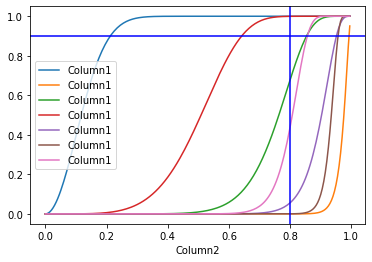

In [29]:
%%time
# b=[2,50,10,5,20,50,20]
# r=[50,2,10,20,5,20,50]


thresh = np.arange(0,1.0,0.005)
br_lst = [(2,50),(50,2),(10,10),(5,20),(20,5),(50,20),(20,50)]
ax = None
for k in br_lst:
  p=[];b=k[0];r=k[1]
  for t in thresh:
    p.append(1-(1-(t**b))**r)
    
  df = pd.DataFrame({'Column1':p, 'Column2':thresh})
  ax = df.plot(ax=ax,x='Column2',y='Column1')
#   plt.rcParams['figure.figsize'] = [10,10]
ax.axvline(x=0.8,color='b')
ax.axhline(y=0.9,color='b')

## Tuning Parameter 
Testing different values for 
- shingles length k
- hash function numbers,  hash_num = r * b
- band numbers b 
- row numbers r,  r = hash_num / bands_num
- similarity threshold can be calculated using s = (1/bands_num)^(1/rows)
- but we selected the 0.8 as it was given in the assignmnet's requirements

We also calculated the Chanse of False Negative in 80% Similarity and Chanse of False Positive in 50% Similarity.

In [30]:
%%time
# Files for Locality Sensitive Hashing Similarity Part
# 1-(1-0.80^r)^b = 0.99

shingles_len = 10
hash_num = 50
bands_num = 10
rows = int(hash_num / bands_num)
# s = (1/bands_num)**(1/rows)
s = 0.80

print("Bands num: ",bands_num,', rows/band: ',rows,", threshold s: ",s)
a=s**rows
x=(1-a)**bands_num
prob=round(1-x,4)
print("Prob. that at least 1 band is identical: ",prob)
print("-------------------------------------------------------------")
print("Chance of False Negative in 80% Similarity: ",round(x,4)," => ",round(100*x,3),"%")
print()

s1=0.5
a=s1**rows
x=(1-a)**bands_num
prob2=round(1-x,4)
print("Chance of False Positive in 50% Similarity: ",round(prob2,4)," => ",round(100*prob2,3),"%")
print()



Bands num:  10 , rows/band:  5 , threshold s:  0.8
Prob. that at least 1 band is identical:  0.9811
-------------------------------------------------------------
Chance of False Negative in 80% Similarity:  0.0189  =>  1.887 %

Chance of False Positive in 50% Similarity:  0.272  =>  27.2 %

Wall time: 999 µs


### Setting the values for the parameters  

In [67]:
%%time
# set the parameters 
# we use this function later 

def num_bands_rows(threshold, num_hashes):
    b = 10
    r = int(num_hashes / b)
    s = (1/b)**(1/r)
    return b, s

print("Threshold: ",round(s,5))
print("rows: ",r)
print("bands: ",b)

Threshold:  0.99
rows:  5
bands:  10
Wall time: 982 µs


### We used  hash_num = 50, b = 10, r = 5, s = 0.8, k = 10
we tried different values like b=7 and r=5, b=10 and r=10, and b=5 and r=2 but we were getting alot of false negative, therefore the b = 10, r = 5 was a perfect choice, also b = 20, r = 6 was another good option, but the b = 20 need more time to compute and for the larger data jupyter crashed, therefore we chose  b = 10, r = 5.

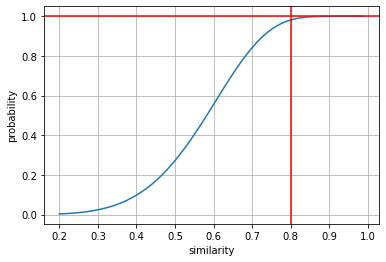

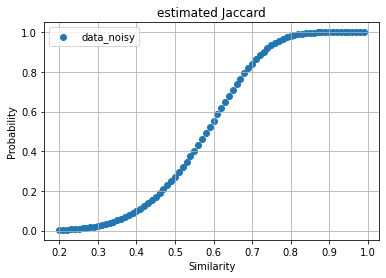

Wall time: 442 ms


In [22]:
%%time

b = 10
r = 5
prob = []
sim = [x for x in np.arange(0.2, 1.0, 0.01)]
for s in sim:
    prob.append((1-pow((1-pow(s,r)),b)))


# axis values 
x = sim
y = prob
  
# plotting the points  
plt.plot(x, y) 
plt.axvline(x=0.8,color='r')
plt.axhline(y=1.0,color='r')
# naming the x axis 
plt.xlabel('similarity') 
# naming the y axis 
plt.ylabel('probability') 
plt.grid() 
# function to show the plot 
plt.show()
# plt.rcParams['figure.figsize'] = [10,10]



prob = []
sim = [x for x in np.arange(0.2, 1.0, 0.01)]
for s in sim:
    prob.append((1-pow((1-pow(s,r)),b)))

x = sim
y = prob

fig, ax = plt.subplots()
ax.scatter(x, y, label='data_noisy')
ax.set_title('estimated Jaccard')
ax.set_xlabel('Similarity') 
ax.set_ylabel('Probability')
ax.grid()
leg = ax.legend()

plt.show()
# plt.rcParams['figure.figsize'] = [10,10]

In [68]:
%%time
# this was an effective class provided by one of the references
# for each band we hash the r hash values for each document. 
# We can use this function to generate a hash function for vectors.


def hash_vector (num_hashes, m=4294967295):
    hashh = make_hashes(num_hashes)
    def function_h(vector):
      acc = 0
      for i in range(len(vector)):
        h = hashh [i]
        acc += h(vector[i])
        return acc % m
    return function_h

Wall time: 0 ns


### Computing LSH

In [70]:
%%time

# try:
#     del lsh_hashes
# except:
#     pass


# lsh_hashes = []
# for i in range(b):
#     lsh_hashes.append({})

#     for j in range(total_docs):

#         col_band = signature_df.loc[i*r:(i+1)*r-1, "Doc"+str(j+1)]
#         col_int = int("".join([str(int(x)) for x in list(col_band)]))
        
#         hash_output = hash_row(*lsh_hash_values[i], col_int, num_buckets)
        
#         if hash_output in lsh_hashes[i]:
#             lsh_hashes[i][hash_output].update(["Doc"+str(j+1)])
#         else:
#             lsh_hashes[i][hash_output] = set(["Doc"+str(j+1)])

# candidate_pairs = []
#print(lsh_hashes)

# for lsh_hash in lsh_hashes:

#     for k,v in lsh_hash.items():

#         if len(v) > 1:
#             candidate_pairs.append(tuple(sorted(list(v))))


# candidate_pairs = set(candidate_pairs)   

# print(" Candidate pairs are ")

# [print(x) for x in candidate_pairs]



def Locality_sensitive_hashing(minhash_sigmatrix, numhashes, docids, threshold):
    
#     b = 10
#     r = 5
#     doc_id = row[0]
#     hash_funct = hashFamily(1)
#     out = []


#  calling num_bands_rows()

  b, _ = num_bands_rows(threshold, numhashes)
  r = int( numhashes / b)
    
  num_of_articles = len(docids)
# calling hash_vector()
  hash_func = hash_vector(r)


  buckets = []
    
  for band in range(b):
    beginnig = int (band * r)
    ending= min ( beginnig + r, numhashes)
    
    this_buckets = defaultdict(list)
    
    
    
    
    for x in range(num_of_articles):
#      The hash function of the r rows for each document make a key in the dictionary.
#      If the other documents in that band make the same hash function 
#      so that document also belong to that key and then the two documents are put in the same bucket.
        key_value = hash_func ( minhash_sigmatrix [beginnig : ending ,x ] )
        single_bucket_dictinary = { key_value :( docids [x] , ) }
        
        
        
        for key in single_bucket_dictinary:
            if key in this_buckets:
                this_buckets[key]+=(single_bucket_dictinary[key])
            else:
                this_buckets[key]=single_bucket_dictinary[key]
         
    buckets.append(this_buckets)
  
  return buckets


# The reduce step will then be a simple groupByKey() and will give us key=(band_id, bucket),value=list of candidates
# Note: an additional map is performed to transform iterable object to list 


# def map_buckets(row):
    

#     for i in range(0,band_nr):
#         band_id = i
#         idx = i*row_nr   
#         set_col = ' '.join(str(x) for x in doc_sign[idx:idx+row_nr])
#         bucket = hash_funct.get_hash_value(set_col)
#         out.append( ( (band_id, bucket), doc_id)  )
    #since we are going to return multiple tuple we call flatMap() and return an iterator on those tuple

#     return iter(out) 

 #the map() is used to convert iterator to a list   
# candidates = sig_matrix.flatMap(map_buckets).groupByKey().map(lambda x : (x[0], list(x[1]))) 





Wall time: 0 ns


In [71]:
%%time
# This function uses the result of our LSH function and returns list of candidate article pairs
# we dont check if the candidates similarity are bigger than s = 0.8
# we are only reading bucket values and combine them 

def Candidate_Similar_Docs(buckets):
    
    candidate_pairs = []
    # lsh_similar = []

# for candidate_pair in candidate_pairs:
#         file1 = int(candidate_pair[0][3:])-1
#         file2 = int(candidate_pair[1][3:])-1

    
    for value in range(len(buckets)):
        
        for key in buckets [value]:
            
#             if there is more than one document in each bucket 
#             it makes a combination of those documents as similar documents.

            if len(buckets[value][key])>1:
                
                for i in range(len (buckets[value][key])-1):
                    
                    candidates = (buckets [value][key][i] , buckets[value][key][i+1] )
                    candidate_pairs.append(candidates)
                    
#         sim = np.sum(signature_df[candidate_pair[0]] == signature_df[candidate_pair[1]])/num_hash_fn
        #print(sim)

#         if sim >= minhash_threshold :
#               lsh_similar.append((filenames[file1],filenames[file2],sim))
#         j += 1  
                    
#     list of tuples (docid1, docid2)  based on LSH  
    return candidate_pairs    




Wall time: 0 ns


In [74]:
# finds the plagiarized articles 
# It uses the candidate_pairs lists that is generated in the Candidate_Similar_Docs() class
# and check the minhash_similarity of the candidates in the minhash signature matrix  
# if it's higher than 80% (s=0.8) it will choose as plagiarized articles

similar_docs = []

def find_Similar_docs (file_name,k,num_hashes,threshold):
        
#   calling shingles_of_documents() class
    shingles = shingles_of_documents(file_name,k)
    

#   calling make_minhash_signature() class
    minhash_sigmat,list_of_documentid=make_minhash_signature(shingles, num_hashes)
    
#   compute Locality_sensitive_hashing
    buckets = Locality_sensitive_hashing(minhash_sigmat, num_hashes, list_of_documentid, threshold)
    
#   retreive the candidate lists that are generated by Candidate_Similar_Docs() class
    candidate_list = Candidate_Similar_Docs(buckets)
    
    
    for i,j in candidate_list:
        
        if (i,j) not in similar_docs:
  # if candidates has a similarity which is higher than 80% (s=0.8) it will choose as plagiarized articles          
            if minhash_similarity(i, j, minhash_sigmat, list_of_documentid) > 0.8:
                
                similar = (i,j)
                similar_docs.append(similar)
                
    return similar_docs   



In [ ]:
%%time
k=10
num_hashes=50
threshold=0.8
file_name="C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Our Data/News_1000.txt"
similar_docs= find_Similar_docs (file_name,k,num_hashes,threshold)
similar_docs

# Write plagiarized articles to a file
with open('plagiarized articles.txt', 'w+') as fp:
    fp.write('Similarity between documents using the Jaccard distance: \n')
    for sims in similar_docs:
        fp.write('\t'.join('%s' % s for s in sims))
        fp.write('')
        fp.write('\n')
fp.close()

## 4.7 LSH Specificity Sensitivity

### This class implemented with help of this references 
- https://github.com/ck-chaudhary/LSH/blob/master/lab4.ipynb
- https://github.com/Pankajdeer/Plagiarism-Detection/blob/main/Plagirism%20Detection%20using%20python.ipynb
- https://github.com/elhamsharifi

Sensitivity: is ratio of true positive to the whole positive

Specificity: is the ratio of false positive to the whole negative


In [78]:
sensitivity = []
specificity = [] 
false_positive = []

# computing the false positive, false negative, true positive.
# computing the sensitivity and specificity of LSH  based on the threshold. 
# candidate pairs and plagiarized articles are used  

# TP = true positive
# FP = false positive
# FN = false negative

def LSH_specificity_sensitivity (file1 , file2 , k , num_hashes):

    plagiarized_instances,_= plagiarized_non_plagiarized_instances(file1, file1)

    shingles= shingles_of_documents(file1,k)
    minhash_sigmat,list_of_documentid=make_minhash_signature(shingles, num_hashes)
    
#   threshold is ranging from 0.2 to 1 in 0.2 steps
    for threshold in np.arange(0.2,1,0.2):
        
        ## False Negatives
    #   FN=[]
    #   for file in list(bucket.keys()):
    
#         if file in list(bucket.keys()):
#               continue
#             else: 
#                   FN.append(file)
#         print("false negtive's count: ", len(FN))
        
    
    
#        cheking the buckets
        buckets= Locality_sensitive_hashing(minhash_sigmat, num_hashes, list_of_documentid, threshold)
        
#       retrieving candidate lists
        candidate_list = Candidate_Similar_Docs(buckets)
        
        # retrieved and relevant
        TP = len ( set (candidate_list).intersection (set (plagiarized_instances)))
       
        # false positive(retrieved and not-relevant) - True positive
        FP = len(candidate_list) - TP
        
#       false negative(not-retrieved and relevant) - True positive
        FN =len(plagiarized_instances)-TP
        
        all_negative = (len(list_of_documentid))**2 - len(candidate_list)
        
        all_positive = len (candidate_list)
        
        # by definition Sensitivity: is ratio of true positive to the whole positive
        Sensitivity_ratio = (1.0 * TP) / all_positive
        
        # by definition Specificity: is the ratio of false positive to the whole negative
        Specificity_ratio = (1.0 * FP)/all_negative
        
        
        sensitivity.append(Sensitivity_ratio)
        specificity.append(Specificity_ratio)
                                
    return sensitivity, specificity


In [ ]:
%%time
k=10
num_hashes=50
file_name1="C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Our Data/News_1000.txt"
file_name2="C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Our Data/Candidate pairs.txt"
sensitivity, specificity = LSH_specificity_sensitivity (file1, file2, k, num_hashes)

#### Run the Min Hash algorithm on different size files, count their response time and write output to a file

In [ ]:
plt.plot(np.arange(0.2,1,0.2),sensitivity)    
plt.plot(np.arange(0.2,1,0.2),specificity) 

plt.legend(['LSH Sensitivity', 'LSH Specificity'],loc=1)

plt.xlabel('Threshhold t')
plt.ylabel('Percentage of Sensitivity and Specificity')

plt.title('LSH Sensitivity and Specificity vs. Threshhold')

plt.xlim(0,1)

## References

- https://medium.com/analytics-vidhya/locality-sensitive-hashing-finding-documents-similarity-6f12d4d83af
- https://www.researchgate.net/publication/291225480_Locality-Sensitive_Hashing_Techniques_for_Nearest_Neighbor_Search
- http://www.cs.uoi.gr/~tsap/teaching/2016-cse012/slides/datamining-lect5.pdf
- https://github.com/CostasPitharoulios/Plagiarism_Detector/blob/master/Jupyter_Notebook/PlagiarismsDetector.ipynb
- https://cse.iitkgp.ac.in/~animeshm/algoml/lsh.pdf
- https://github.com/himalayanZephyr/finding_similar_documents/blob/master/similar_items.ipynb
- https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/
- https://cse.iitkgp.ac.in/~sourangshu/coursefiles/SDM18A/07-LSH-1.pdf
- https://github.com/elhamsharifi?tab=repositories
- https://unboxresearch.com/articles/lsh_post1.html
- https://github.com/vgole001/Count-Distinct-Items-using-Min-Hash-and-LSH/blob/master/MinHash_LSH.ipynb
- https://towardsdatascience.com/understanding-locality-sensitive-hashing-49f6d1f6134
- https://github.com/Pankajdeer/Plagiarism-Detection/blob/main/Plagirism%20Detection%20using%20python.ipynb
- https://www.sciencedirect.com/science/article/abs/pii/S0957417418300149
- https://github.com/davidtag/cs166-project/blob/master/Experiment_Starter.ipynb
- https://www.researchgate.net/publication/291225480_Locality-Sensitive_Hashing_Techniques_for_Nearest_Neighbor_Search
- https://github.com/pyt243/IR-LSH
